<a href="https://colab.research.google.com/github/orifelszer/CrimeData/blob/oriana-branch/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
import requests
import zipfile
from io import BytesIO
from threadpoolctl import threadpool_limits
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:

# Force single-threaded BLAS usage to avoid conflicts
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

# GitHub raw URLs for .zip files
base_url = "https://github.com/orifelszer/CrimeData/raw/main/"
files = {"X_train": "X_train_supervised.zip", "X_test": "X_test_supervised.zip"}

# Function to fetch and load data
def load_data_from_repo(file_name):
    url = base_url + file_name
    response = requests.get(url, timeout=60)
    if response.status_code == 200:
        with zipfile.ZipFile(BytesIO(response.content)) as z:
            extracted_file_name = z.namelist()[0]
            with z.open(extracted_file_name) as f:
                return pd.read_csv(f)
    else:
        raise Exception(f"Failed to download {file_name}. HTTP status code: {response.status_code}")

# Load datasets
X_train = load_data_from_repo(files["X_train"])
X_test = load_data_from_repo(files["X_test"])

# Combine train and test datasets
combined_data = pd.concat([X_train, X_test], ignore_index=True)

# Sampling a subset
sampled_data = combined_data.sample(n=100000, random_state=42)

# Features for clustering
features_for_clustering = sampled_data[['YeshuvCrimeRate', 'CrimeTrend', 'Quarter_sin', 'Quarter_cos', 'StatisticArea']]

# Dimensionality reduction with TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_features = svd.fit_transform(features_for_clustering)

# MiniBatchKMeans clustering with threadpool limits
kmeans = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=10000, n_init="auto")
with threadpool_limits(limits=1, user_api="blas"):  # Enforce single-threaded BLAS operations
    sampled_data['Cluster'] = kmeans.fit_predict(reduced_features)

# Save results
output_file_path = 'sampled_data_with_clusters.csv'
sampled_data.to_csv(output_file_path, index=False)

# Display cluster summary
cluster_summary = sampled_data['Cluster'].value_counts().sort_index()
print("Cluster Summary:")
print(cluster_summary)
print(f"Clustered dataset saved to: {output_file_path}")


Cluster Summary:
Cluster
0    27397
1    21329
2    17555
3    21444
4    12275
Name: count, dtype: int64
Clustered dataset saved to: sampled_data_with_clusters.csv


In [2]:
from google.colab import files
files.download('sampled_data_with_clusters.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

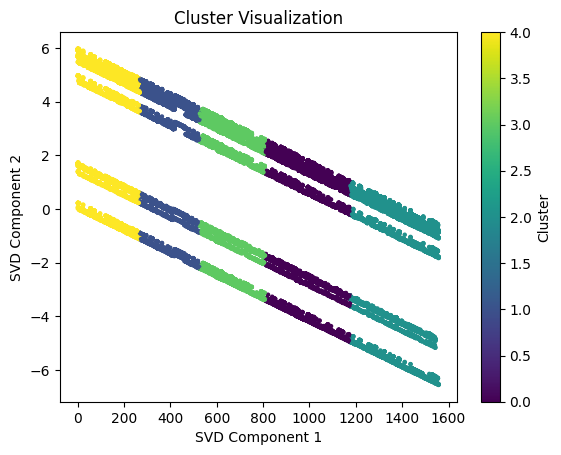

In [3]:
import matplotlib.pyplot as plt

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=sampled_data['Cluster'], cmap='viridis', s=5)
plt.colorbar(label='Cluster')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('Cluster Visualization')
plt.show()


In [4]:
cluster_features = sampled_data.groupby('Cluster').mean()
print(cluster_features)


                Year      Yeshuv  PoliceStation  StatisticArea  \
Cluster                                                          
0        2021.368873  127.269738      43.928678     972.508231   
1        2021.391439  118.697689      37.361480     405.856018   
2        2021.384392  112.251495      38.800171    1375.688977   
3        2021.378334  158.817898      48.679724     644.912796   
4        2021.347210  124.913157      42.489776     128.799593   

         is_missing_StatisticArea  Quarter_numeric  Quarter_sin  Quarter_cos  \
Cluster                                                                        
0                        0.461182         2.433113     0.002190    -0.043618   
1                        0.446106         2.429040    -0.017582    -0.057199   
2                        0.095870         2.433666     0.004956    -0.042609   
3                        0.376795         2.445206    -0.014596    -0.042949   
4                        0.000000         2.439104    -0.

<ipython-input-6-ac093b6010c0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sampled_data, x='Cluster', y='YeshuvCrimeRate', palette='viridis')


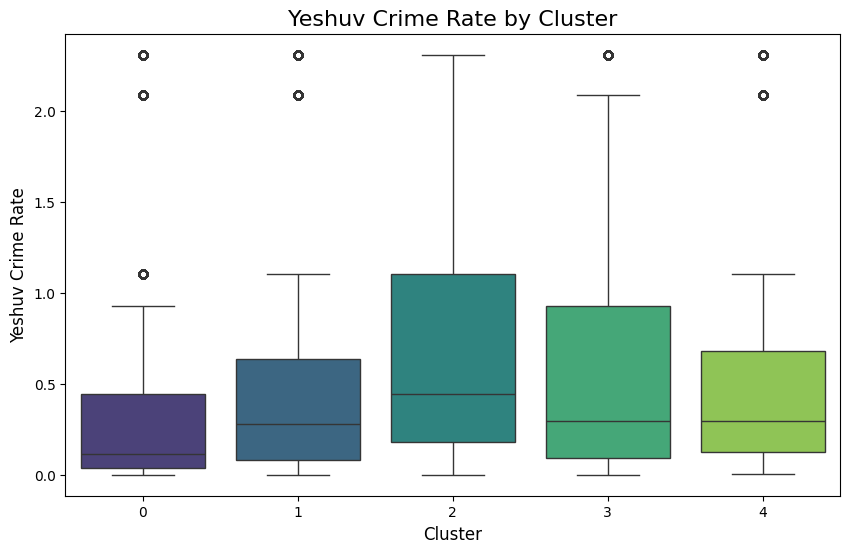

In [6]:
# Boxplot of Yeshuv Crime Rate by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=sampled_data, x='Cluster', y='YeshuvCrimeRate', palette='viridis')
plt.title('Yeshuv Crime Rate by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Yeshuv Crime Rate', fontsize=12)
plt.show()


What it shows: The distribution of the YeshuvCrimeRate (crime rate in each locality) for each cluster.
Observations:
Cluster 2 and Cluster 3 have higher crime rates on average compared to other clusters.
Cluster 0 has the lowest crime rate, indicating it might represent safer areas.

<ipython-input-7-1edaf171febc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sampled_data, x='Cluster', y='CrimeTrend', palette='viridis')


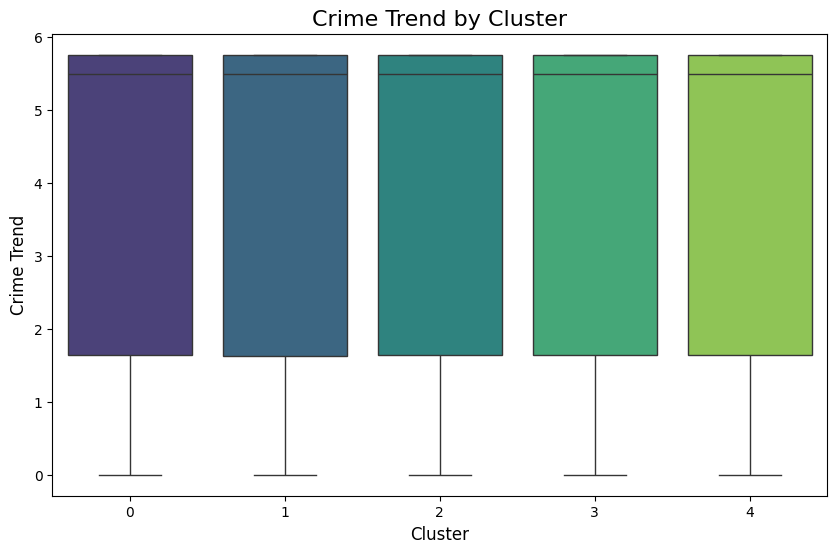

In [7]:
# Boxplot of Crime Trend by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=sampled_data, x='Cluster', y='CrimeTrend', palette='viridis')
plt.title('Crime Trend by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Crime Trend', fontsize=12)
plt.show()


What it shows: The distribution of the CrimeTrend (overall trend of crimes over time) for each cluster.
Observations:
Crime trends are similar across clusters, with slightly higher variations in certain clusters (e.g., Cluster 2 and Cluster 3).
Indicates that while crime rates might differ, overall trends could still align.

<ipython-input-8-ddbd7a75d9c0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


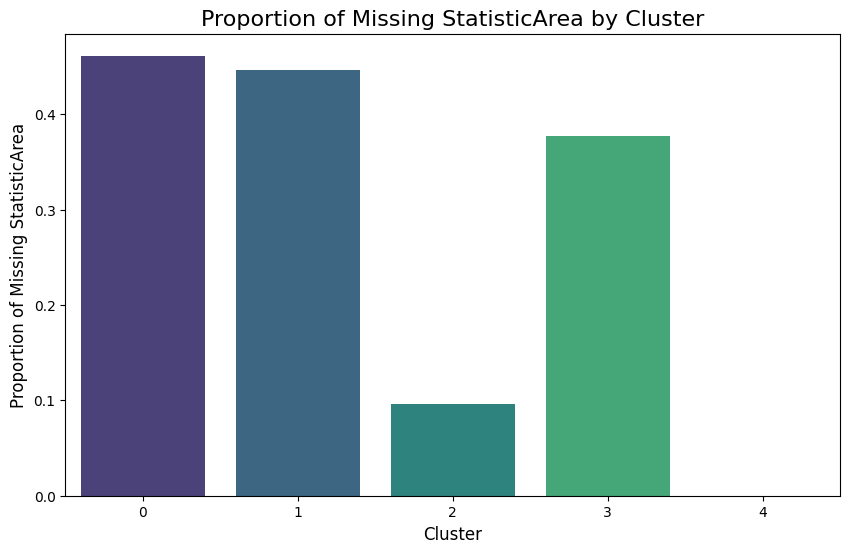

In [8]:
# Barplot for proportion of missing StatisticArea values
plt.figure(figsize=(10, 6))
sns.barplot(
    data=sampled_data.groupby('Cluster')['is_missing_StatisticArea'].mean().reset_index(),
    x='Cluster', y='is_missing_StatisticArea', palette='viridis'
)
plt.title('Proportion of Missing StatisticArea by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Proportion of Missing StatisticArea', fontsize=12)
plt.show()


What it shows: The proportion of missing values in the StatisticArea feature for each cluster.
Observations:
Cluster 2 has the least missing values (almost none), while Clusters 0 and 1 have the highest proportions of missing data.
This suggests Cluster 2 might represent areas where data collection is more reliable or complete.


It looks like you're summarizing the steps for interpreting the clusters based on the visualizations. Let’s expand on this and make the next steps clearer so that you can build a concrete action plan or analysis.

1. High Crime Clusters (Clusters 2 and 3)
Observations:
Clusters 2 and 3 have higher crime rates (YeshuvCrimeRate) and possibly higher crime trends (CrimeTrend).
Actionable Insights:
Urban Areas: These clusters could represent urban or densely populated areas. Urban areas tend to have more complex crime dynamics, so further analysis of infrastructure and law enforcement might be useful.
Resource Allocation: Focus law enforcement or community resources on these regions. Investigate if crime is more concentrated in specific locations (e.g., certain neighborhoods) or during certain periods (seasonal trends).

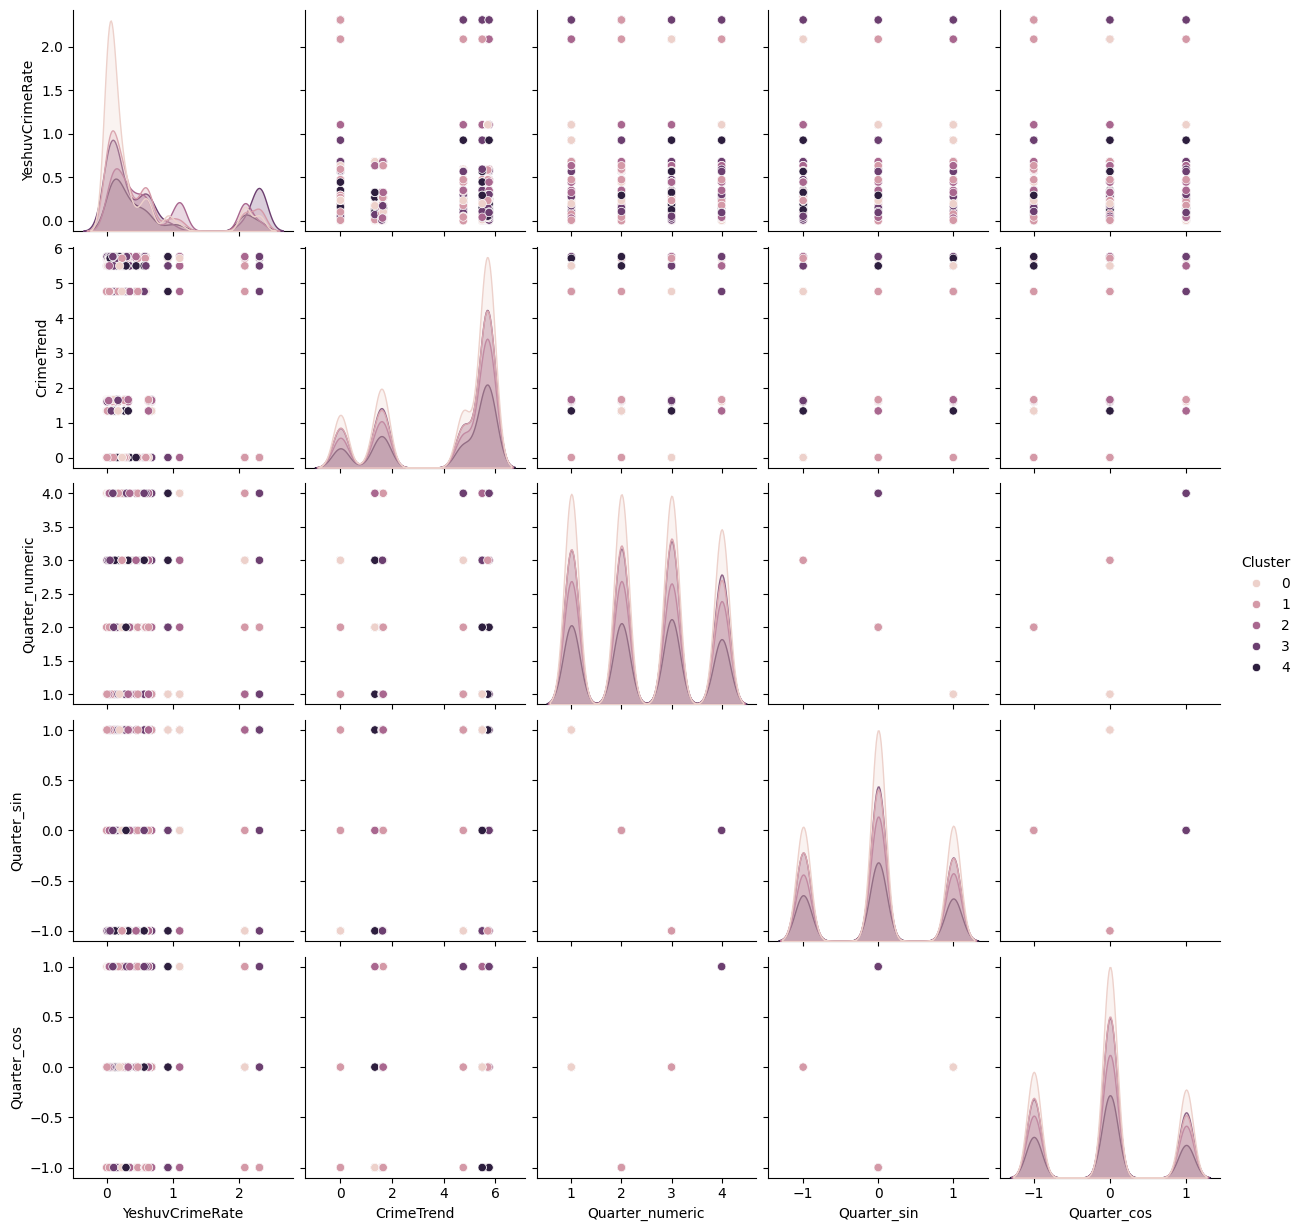

In [13]:
# Investigating relationships between CrimeRate, CrimeTrend, and Quarter features
sns.pairplot(sampled_data[['YeshuvCrimeRate', 'CrimeTrend', 'Quarter_numeric', 'Quarter_sin', 'Quarter_cos', 'Cluster']], hue='Cluster')
plt.show()


Key Insights from the Pair Plot:
YeshuvCrimeRate and CrimeTrend:

Crime Rate Distribution: The YeshuvCrimeRate feature shows that clusters are separated based on crime rates. For example:
Cluster 0 seems to have the lowest values, possibly representing low-crime or rural areas.
Cluster 2 and Cluster 3 have the highest values, likely indicating high-crime regions.
Crime Trend Peaks: CrimeTrend shows significant peaks in some clusters (especially Cluster 3), indicating that these areas might have dramatic crime spikes or trends over time.
Quarter Features (Quarter_numeric, Quarter_sin, Quarter_cos):

These cyclical features (representing quarters of the year) display seasonal patterns, especially in Cluster 2 and Cluster 3.
The peaks and valleys in these features suggest that crime trends in these clusters might be seasonal (e.g., higher crimes in certain quarters of the year).
Seasonal Crime: Areas in clusters 2 and 3 might have more noticeable seasonal crime trends, while Cluster 0 has more uniform patterns.
Cluster Separation:

The different clusters are represented by color (0 through 4), and you can see that the clusters are clearly separated in terms of YeshuvCrimeRate and CrimeTrend.
Cluster 0 has lower crime rates, and its seasonal behavior is distinct compared to the others.
Clusters 2 and 3 show more distinct seasonal variations and have higher crime trends.
Weak Correlations Between Features:

There isn’t much correlation between Quarter_sin and Quarter_cos with YeshuvCrimeRate or CrimeTrend, but they seem to help in separating the clusters based on seasonality.
The peaks in Quarter_numeric suggest that clustering has correctly grouped areas with similar seasonal patterns.

2. Low Crime Clusters (Cluster 0)
Observations:
Cluster 0 shows the lowest crime rate on average.
Actionable Insights:
Potentially Safer Areas: This could represent rural areas or regions with better infrastructure, law enforcement, or community engagement.
Policy for Preservation: Even though these areas are safer, they could benefit from proactive policing or community programs to maintain the low crime rate.

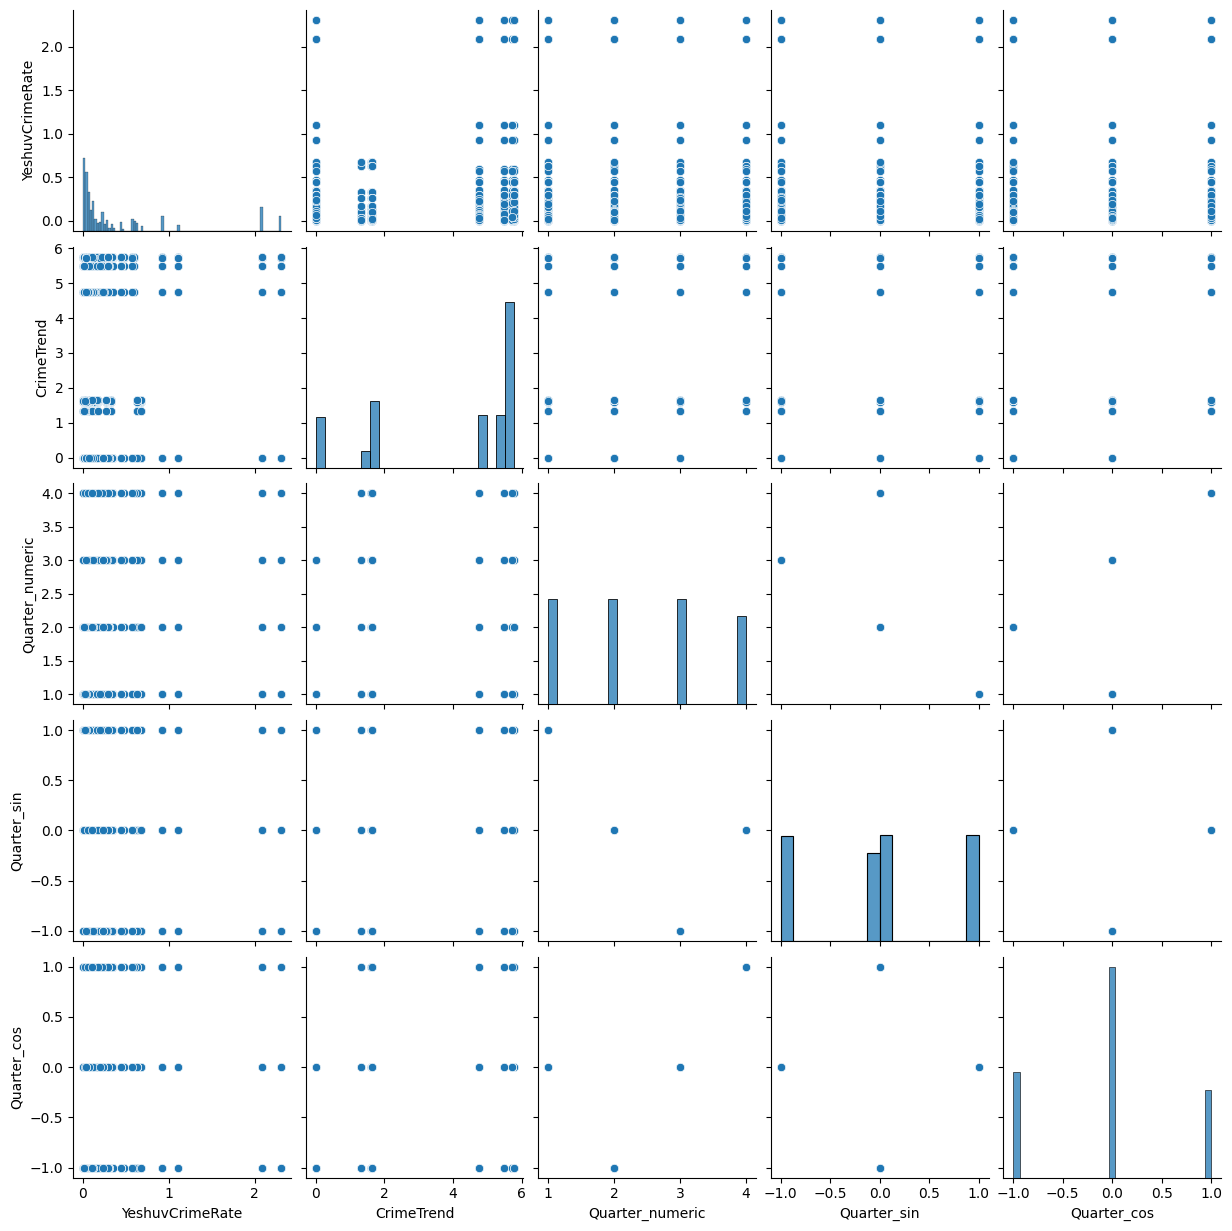

In [14]:
# Investigate the relationship between crime rate and other features for Cluster 0
cluster_0 = sampled_data[sampled_data['Cluster'] == 0]
sns.pairplot(cluster_0[['YeshuvCrimeRate', 'CrimeTrend', 'Quarter_numeric', 'Quarter_sin', 'Quarter_cos']])
plt.show()


Geo-Spatial Mapping
Goal: Visualize clusters on a map to understand their geographical context (if StatisticArea corresponds to geographical data such as latitudes and longitudes).
What to Do Next:
Create a Map: If you have latitude and longitude data, you can use libraries like folium to plot the clusters on a map. This will help you visually identify patterns in crime distribution.